In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import requests, zipfile, io
import re
import pysrt
import string
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline

# Contents

<ol>
<li><a href="#intro">Problem Statement</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#sentiment">Sentiment Analysis - Initial Observations</a></li>
    <a href="#pvsb">Polarity vs Boxoffice results - 90s movies</a> <br>
    <a href="#pvsr">Polarity vs IMDB ratings - 90s movies</a> <br>
    
<li><a href='#arc'> Emotional Arc of movies</a>
<li><a href='#topic'> Topic Modeling  </a>    
</ol>


## Problem Statement:

Renowned Author Kurt Vonnegut was a Master's student in Anthropology at University of Chicago. His Master's thesis was rejected because the premise seemed too simple and looked fun. But he was onto something. The premise as best said by Vonnegut himself is, "The fundamental idea is that stories have shapes which can be drawn on graph paper, and that the shape of a given society’s stories is at least as interesting as the shape of its pots or spearheads."

The shape Vonnegut was referring to is the rise and fall of sentiment from start to finish for each story. Now, we have the tools to plot the sentiment of text. You can find numerous examples online where sentiment for different mediums were plotted. I wanted to plot the sentiment or emotional arc of Disney movies and analyze. 

I also wanted to perform Topic Modeling analysis of the movies to identify common themes. 

The work flow will be,
1) Create the corpus
2) Perform Sentiment analysis
3) Perform Topic Modeling

So let's get started and the first task is to get the corpus. The corpus consists of the transcript of each movie and I thought subtitle files are a good source. Hence we need to scrape subtitle files and extract the text from each.

 


## Data Wrangling

<ul>
<li>A) Create a list of movies </li>
<li>B) Obtain Summary statistics from IMDB </li>
<li>C) Obtain Summary statistics from OMDB </li>
<li>D) Identify a source for subtitle files and download the files </li>
    Source: yts-subs.com hosted subtitle files and allowed to search and download each subtitle file programmatically.  
<li>E) Extract the text from each file </li>
</ul>

#### A) List of movies with summary statistics

In [12]:
#list of disney movies created manually
disney_df = pd.read_csv('disney_list.csv')

In [1]:
# disney_df.head()

In [1]:
# disney_df.info()

#### B) Summary statistics from IMDB

IMDB is the most popular database for movies and it provided datasets for download. Many movie databases in the internet used the IMDB movie id as the primary key hence we will start here. 

In [5]:
#IMDB database files downloaded from https://datasets.imdbws.com/
df_imdb_basics = pd.read_csv(r'C:\Users\vbatt\JupyterNotebooks\NLP\movie_subtitles\IMDB\basics.tsv',sep='\t')

C:\Users\vbatt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#cleaning and casting year field for merge
df_imdb_basics = df_imdb_basics[df_imdb_basics['startYear'] != '\\N']
df_imdb_basics['startYear'] = df_imdb_basics['startYear'].astype('int64')
# df_imdb = df_imdb_basics[df_imdb_basics['startYear'] != '\\\\N']

In [2]:
# df_imdb_basics.info()

In [14]:
#merge with imdb database to add imdb movie id
disney_df = pd.merge(disney_df,df_imdb_basics[['primaryTitle','startYear','tconst','titleType','runtimeMinutes']],left_on=['title','year'],right_on=['primaryTitle','startYear'],how='left')

In [15]:
#removing non-movie types
disney_df = disney_df[disney_df['titleType'].str.contains('movie')==True]

In [16]:
#finding duplicates
disney_df[disney_df['title'].duplicated()]

,title,year,productionStudio,primaryTitle,startYear,tconst,titleType,runtimeMinutes
70,Cinderella,2015,Via Disney,Cinderella,2015.0,tt5089556,movie,113
80,Coco,2017,Via Disney/Pixar,Coco,2017.0,tt7002100,movie,98
226,Pocahontas,1995,Via Disney,Pocahontas,1995.0,tt9047432,movie,53
288,The Hunchback of Notre Dame,1996,Via Disney,The Hunchback of Notre Dame,1996.0,tt9799878,movie,65


In [18]:
#disney_df[disney_df['title'].str.contains('Cinderella|Coco|Pocahontas|The Hunchback of Notre Dame')==True]

In [19]:
#removing duplicates
disney_df = disney_df[disney_df['tconst'].str.contains('tt9799878|tt5089556|tt7002100|tt9047432')==False]

In [21]:
#removing duplicate columns due to merge
disney_df = disney_df.drop(['primaryTitle','startYear','titleType'], axis='columns')

In [3]:
# disney_df.head()

#### C) Scraping data from OMDB Database 

OMDB database http://www.omdbapi.com/ provides movie information and all in one place unlike IMDB.

In [22]:
movie_list = disney_df['tconst']
omdb_data = []

In [23]:
for movieID in movie_list:
        url = (f'http://www.omdbapi.com/?i={movieID}&apikey=f5c31e3d')
#         print(url)
        api_data = requests.get(url).text
        soup = BeautifulSoup(api_data)
        omdb_data.append(eval(soup.p.text))

In [26]:
df_omdb = pd.DataFrame(omdb_data)

In [5]:
# df_omdb.head(1)

In [30]:
#merge with omdb data
disney_df = pd.merge(disney_df,df_omdb[['imdbID','imdbVotes','imdbRating','BoxOffice','Genre','Director']], left_on='tconst',right_on='imdbID',how='left')

In [31]:
disney_df.head()

,title,year,productionStudio,tconst,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Runtime,Genre,Director
0,10 Things I Hate About You,1999,Via Disney,tt0147800,97,tt0147800,"319,527","$38,178,166",7.3,97 min,"Comedy, Drama, Romance",Gil Junger
1,101 Dalmatians,1996,Via Disney,tt0115433,103,tt0115433,"108,703","$136,189,294",5.7,103 min,"Adventure, Comedy, Crime",Stephen Herek
2,A Bug's Life,1998,Via Disney/Pixar,tt0120623,95,tt0120623,"280,662","$162,798,565",7.2,95 min,"Animation, Adventure, Comedy","John Lasseter, Andrew Stanton"
3,Aladdin,1992,Via Disney,tt0103639,90,tt0103639,"391,268","$217,350,219",8.0,90 min,"Animation, Adventure, Comedy","Ron Clements, John Musker"
4,Alice in Wonderland,1951,Via Disney,tt0043274,75,tt0043274,"136,088",N/A,7.4,75 min,"Animation, Adventure, Comedy","Clyde Geronimi, Wilfred Jackson, Hamilton Luske"


##### Data Cleaning

In [7]:
#dropping duplicate
disney_df.drop('tconst',axis='columns',inplace=True)

In [33]:
#replacing N/A with 0 so numeric functions can be used
disney_df['imdbVotes'] = disney_df['imdbVotes'].str.replace('N/A','0')

In [34]:
#cleaning BoxOffice string to int
disney_df['BoxOffice'] = disney_df['BoxOffice'].str.replace('N/A','0')
disney_df['BoxOffice'] = disney_df['BoxOffice'].str.replace(',', '').str.replace('$', '').astype(int)

C:\Users\vbatt\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [37]:
disney_df.head(1)

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director
0,10 Things I Hate About You,1999,Via Disney,97,tt0147800,"319,527",38178166,7.3,"Comedy, Drama, Romance",Gil Junger


In [38]:
disney_df.to_excel('disney_df_final.xlsx')

In [40]:
# disney_df_final = pd.read_excel('disney_df_final.xlsx', index_col=0)

#### D) Scraping and Cleaning Subtitles from yts-subs.com

yts-subs.com lists all the subtitles available for each movie in a page. The user can then pick a specific subtitle for desired language. The link leads to a subtitle download page where user can download a zip file containing the subtitle.

Workflow:
<ol>
<li> First task is to open each movie's page in yts-sub.com domain and find the first link for an English subtitle</li> 
<li> Second task is to fetch the download link from the download page</li>
<li> Download the zip file and unzip the subtitle .srt file to local folder</li>
<li> Open the subtitle .srt file and extract the text for each movie</li>
</ol>

In [45]:
def get_sub_link(movieID):
    '''
    To scrape link to a movie's subtitle page from https://yts-subs.com/
    Record entry for each movie, if subtitles was not available or if English subtitles was not available
    '''

    url = (f'https://yts-subs.com/movie-imdb/{movieID}')
    results_page = requests.get(url).text
    soup = BeautifulSoup(results_page,'lxml')

    if soup.head.title.text == 'YIFY Subtitles - subtitles for YIFY movies':
        s_link = 'no subtitles available'
    else:
        table_body = soup.find('tbody')
        rows = table_body.find_all('tr')

        for row in rows:
            cols = row.find('span',class_="sub-lang")
            if cols.text == 'English':
                s_link = row.find('a')['href']
                break
            else:
                s_link = 'no English subtitles'
            
    return s_link

In [43]:
disney_df['sub_link'] = np.NaN

In [47]:
#fetch and save the links to subtitles files
start = time.time()

for idx,row in disney_df.iterrows():
    disney_df.loc[idx, 'sub_link'] = get_sub_link(row.loc['imdbID'])
    
end = time.time()
print("Runtime:", end - start)

Runtime: 35.62577819824219


In [51]:
#checking for NA values
disney_df[disney_df['sub_link'].isna()]

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director,sub_link


In [49]:
#movies for which a link was not found
disney_df[disney_df.sub_link.str.contains('no subtitles available' or 'no English subtitles')]

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director,sub_link
7,Babes in Toyland,1961,Via Disney,106,tt0054649,"4,015",10218316,6.2,"Comedy, Family, Fantasy",Jack Donohue,no subtitles available
66,The Brave Little Toaster,1987,Via Disney,90,tt0092695,"25,050",0,7.3,"Animation, Adventure, Family",Jerry Rees,no subtitles available


In [52]:
disney_df = disney_df.drop(disney_df[(disney_df['sub_link'] == 'no English subtitles') | (disney_df['sub_link'] == 'no subtitles available')].index)

In [8]:
# disney_df.shape

In [9]:
# disney_df.head(1)

In [56]:
def get_zip_link(short_link):
    '''
        Scrape the subtitle download page and get the subtitle zip file link
    '''
    url = (f'https://yts-subs.com{short_link}')
    sub_page = requests.get(url).text
    soup = BeautifulSoup(sub_page,'lxml')
    zip_link = soup.find('a',class_='btn-icon download-subtitle')['href']
    
    return zip_link

In [57]:
disney_df['zip_link'] = np.NaN

In [58]:
start = time.time()

for idx,row in disney_df.iterrows():
    disney_df.loc[idx, 'zip_link'] = get_zip_link(row.loc['sub_link'])
    
end = time.time()
print("Runtime:", end - start)

Runtime: 30.029327154159546


In [61]:
disney_df.to_excel('disney_df_ziplink.xlsx')
# disney_df = pd.read_excel('disney_df_ziplink.xlsx', index_col=0)

In [65]:
def download_zip(link):
    '''
        Download the zip file from link provided and extract subtitle to a local folder and return the name of file 
        or error message if link was dead
    '''
    req = requests.get(link)
    if req.ok:
        zip_file = zipfile.ZipFile(io.BytesIO(req.content))
        zip_file.extractall('C:\\Users\\vbatt\\JupyterNotebooks\\NLP\\movie_subtitles\\ytssubs')
        result = zip_file.namelist()[0]
        
    else:
        result = (f'Request Failed: {link}')
    
    return result

In [66]:
disney_df['zip_file_name'] = np.NaN

In [67]:
#execute download_zip function and save the file name
start = time.time()

for idx,row in disney_df.iterrows():
    disney_df.loc[idx, 'zip_file_name'] = download_zip(row.loc['zip_link'])
    
end = time.time()
print("Runtime:", end - start)

Runtime: 58.47820997238159


In [10]:
# disney_df.tail(1)

In [71]:
#checking for failed requests
disney_df[disney_df['zip_file_name'].str.contains('Request Failed')]

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director,sub_link,zip_link,zip_file_name
2,A Bug's Life,1998,Via Disney/Pixar,95,tt0120623,"280,662",162798565,7.2,"Animation, Adventure, Comedy","John Lasseter, Andrew Stanton",/subtitles/a-bugs-life-1998-english-yify-37617,https://yifysubtitles.org/subtitle/a-bugs-life...,Request Failed: https://yifysubtitles.org/subt...
11,Big Hero 6,2014,Via Disney,102,tt2245084,"435,337",222527828,7.8,"Animation, Action, Adventure","Don Hall, Chris Williams",/subtitles/big-hero-6-2014-english-yify-126597,https://yifysubtitles.org/subtitle/big-hero-6-...,Request Failed: https://yifysubtitles.org/subt...


In [76]:
#dropping the small number of records
disney_df = disney_df.drop(disney_df[disney_df['zip_file_name'].str.contains('Request Failed')==True].index)

In [106]:
#Windows automatically converted filenames with ':' to '_'
disney_df[disney_df['zip_file_name'].str.contains(':')]

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director,sub_link,zip_link,zip_file_name,subtitles
5,Atlantis: The Lost Empire,2001,Via Disney,95,tt0230011,"112,942",84056472,6.9,"Animation, Action, Adventure","Gary Trousdale, Kirk Wise",/subtitles/atlantis-the-lost-empire-2001-engli...,https://yifysubtitles.org/subtitle/atlantis-th...,Atlantis: The Lost Empire-English.srt,NaN
20,DuckTales the Movie: Treasure of the Lost Lamp,1990,Via Disney,74,tt0099472,"26,252",18115724,6.9,"Animation, Adventure, Comedy",Bob Hathcock,/subtitles/ducktales-the-movie-treasure-of-the...,https://yifysubtitles.org/subtitle/ducktales-t...,DuckTales.the.Movie:.Treasure.of.the.Lost.Lamp...,NaN
51,Pirates of the Caribbean: The Curse of the Bla...,2003,Via Disney,143,tt0325980,"1,055,159",305413918,8.0,"Action, Adventure, Fantasy",Gore Verbinski,/subtitles/pirates-of-the-caribbean-the-curse-...,https://yifysubtitles.org/subtitle/pirates-of-...,Pirates of the Caribbean: The Curse of the Bla...,NaN
57,Sister Act 2: Back in the Habit,1993,Via Disney,107,tt0108147,"52,262",57319029,5.7,"Comedy, Family, Music",Bill Duke,/subtitles/sister-act-2-back-in-the-habit-1993...,https://yifysubtitles.org/subtitle/sister-act-...,Sister Act 2: Back in the Habit-English.srt,NaN
67,"The Chronicles of Narnia: The Lion, the Witch ...",2005,Via Disney,143,tt0363771,"383,022",291710957,6.9,"Adventure, Family, Fantasy",Andrew Adamson,/subtitles/the-chronicles-of-narnia-the-lion-t...,https://yifysubtitles.org/subtitle/the-chronic...,The Chronicles of Narnia: The Lion the Witch a...,NaN


In [107]:
#correcting filenames with ':'
for idx,row in disney_df.iterrows():
    disney_df.loc[idx, 'zip_file_name'] = row.loc['zip_file_name'].replace(':','_')


In [108]:
disney_df[disney_df['zip_file_name'].str.contains(':')]

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director,sub_link,zip_link,zip_file_name,subtitles


In [ ]:
#some files are not srt
disney_df[disney_df['zip_file_name'].str.contains('ssa')]

In [ ]:
#dropping the only record
disney_df = disney_df.drop(disney_df[disney_df['zip_file_name'].str.contains('ssa')==True].index)

#### E) Extracting Text from subtitle files

In [109]:
#import pysrt
def extract_clean_sub(file_name):
    '''
        Extract the text from each subtitle .srt file using pysrt and clean the text from unwanted characters/text
    '''

    file = (f'ytssubs\\{file_name}') #attach the subfolder name to filename
    subs=pysrt.open(file, encoding='ISO-8859-1')
    text = subs.text
    
    #cleaning the subtitles
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)  # removes all [] and text within 
    text = re.sub('<[^>]*>', '', text)  # removes all <> and text within
    text = re.sub('\([^)]*\)', '', text) # removes all () and text within
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # removes punctuations
    text = re.sub('\w*\d\w*', '', text) #removes numbers
    text = re.sub('[‘’“”♪…]', '', text) #removes "" 
    text = re.sub('\n', ' ', text) #remove new line \ n characters
    text = "".join(c for c in text if ord(c)<128)  # remove non ascii characters

            
    return text


In [79]:
disney_df['subtitles'] = np.NaN

In [110]:
#executing extract_clean_sub function
start = time.time()

for idx,row in disney_df.iterrows():
    disney_df.loc[idx, 'subtitles'] = extract_clean_sub(row.loc['zip_file_name'])
    
end = time.time()
print("Runtime:", end - start)

Runtime: 3.1205942630767822


In [112]:
disney_df[disney_df['subtitles'].isna()]

,title,year,productionStudio,runtimeMinutes,imdbID,imdbVotes,BoxOffice,imdbRating,Genre,Director,sub_link,zip_link,zip_file_name,subtitles


In [114]:
disney_df['subtitles'][0]

'hey ill be right with you so cameron here you go nine schools in   years my my army brat yeah my dad is thats enough im sure you wont find padua any different than your old schools same little asswipe shitforbrains everywhere excuse me did you just say am i in the right office not anymore youre not ive got deviants to see and a novel to finish now scoot scoot okay thanks thanks a lot patrick verona i see were making our visits a weekly ritual only so we can have these moments together should i hit the lights oh very clever kangaroo boy says here you exposed yourself in the cafeteria i was joking with the lunch lady it was a bratwurst bratwurst arent we the optimist next time keep it in your pouch okay scoot hello michael eckman im supposed to show you around oh hi thank god you know normally they send down one of those audio visual geeks no i do i know what you mean hey michael where should i put those slides michael so cameron heres the breakdown over there weve got your basic beauti

In [137]:
disney_df_final = disney_df.drop(['sub_link','zip_link','zip_file_name'],axis='columns')

In [138]:
disney_df_final.to_excel('disney_df_final.xlsx')

In [6]:
disney_df_final = pd.read_excel('disney_df_final.xlsx', index_col=0) 
#index needs to be title so you can display name of movie in graphs

In [4]:
# disney_df_final = disney_df_final.drop(disney_df_final.columns[0],axis='columns')

In [11]:
# disney_df_final.info()

In [12]:
# disney_df_final.head(2)

<a id='sentiment'></a>
## Sentiment Analysis - Full Movie
### Polarity and Subjectivity EDA

In [9]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

disney_df_final['polarity'] = disney_df_final['subtitles'].apply(pol)
disney_df_final['subjectivity'] = disney_df_final['subtitles'].apply(sub)


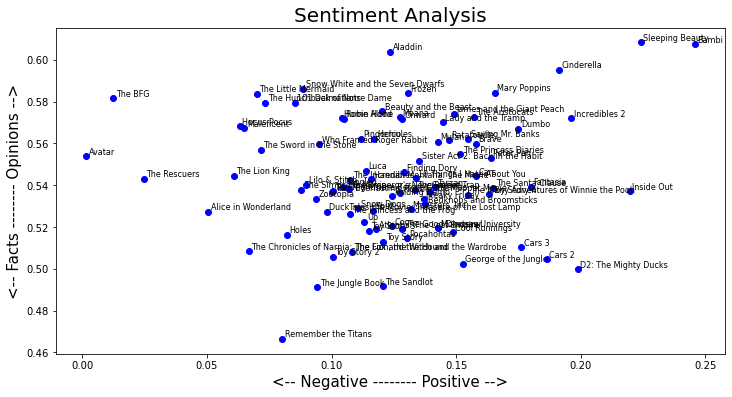

In [18]:
#plotting polarity vs subjectivity
plt.rcParams['figure.figsize'] = [12, 6]

for idx,row in disney_df_final.iterrows():
    x = disney_df_final.loc[idx, 'polarity']
    y = disney_df_final.loc[idx, 'subjectivity']
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, row.loc['title'], fontsize=8)
   
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

### Investigating relation between Polarity and Boxoffice results - 90s movies

Reducing comparison to movies 1990 to 1999 to restrict the comparison of 

In [15]:
disney_df_1990_99 = disney_df_final[(disney_df_final['year'] >= 2000) & (disney_df_final['year'] < 2010)]
# disney_df_1990_99.head(2)

In [176]:
# disney_df_1990_99 = disney_df_1990_99.reset_index()

<a id='pvsb'></a>

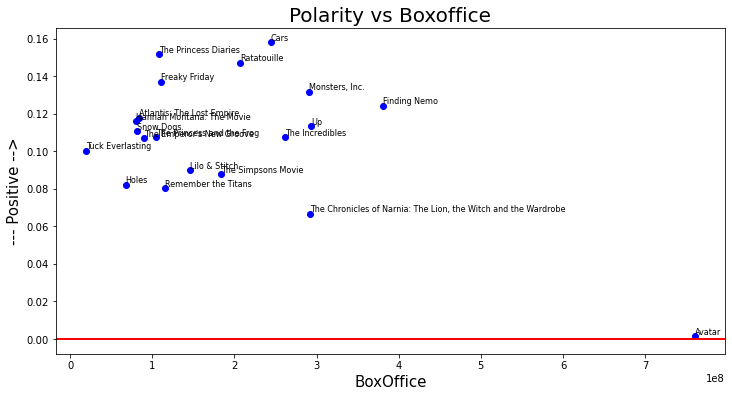

In [17]:
plt.rcParams['figure.figsize'] = [12, 6]

for idx,row in disney_df_1990_99.iterrows():

    x = row.loc['BoxOffice']
    y = row.loc['polarity']
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, row.loc['title'], fontsize=8)
    plt.axhline(y=0, color='r', linestyle='-')
    
plt.title('Polarity vs Boxoffice', fontsize=20)
plt.ylabel('--- Positive -->', fontsize=15)
plt.xlabel('BoxOffice', fontsize=15)

plt.show()

<a id='pvsr'></a>

### Investigating relation between Polarity and IMDB Rating - 90s movies

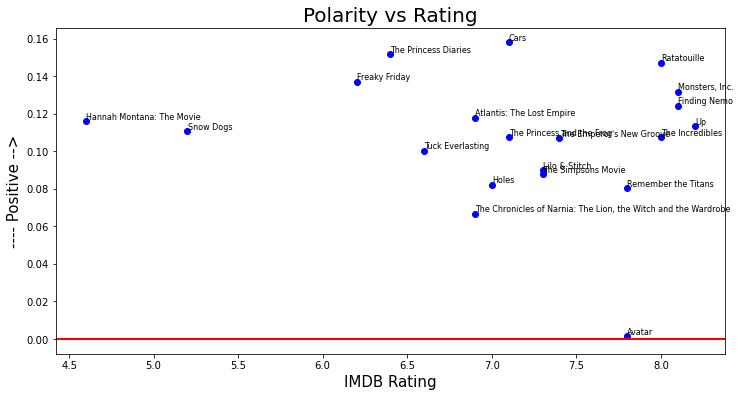

In [19]:
plt.rcParams['figure.figsize'] = [12, 6]

for idx,row in disney_df_1990_99.iterrows():
    x = row.loc['imdbRating']
    y = row.loc['polarity']
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, row.loc['title'], fontsize=8)
    plt.axhline(y=0, color='r', linestyle='-')


plt.title('Polarity vs Rating', fontsize=20)
plt.ylabel('---- Positive -->', fontsize=15)
plt.xlabel('IMDB Rating', fontsize=15)

plt.show()

 <h4> Conclusion: An apparent relationship is not evident in these graphs. I will have to continue from other perspectives. </h4>


---

<a id='arc'></a>
## Sentiment Analysis - Emotional Arc

Instead of using one metric for the whole movie, I would next like to split the movie into parts and see how the polarity changes during the movie. 

In [21]:
def partition_polarity(text, n):
    '''Takes in a string of text and splits into n equal parts, with a default of n equal parts.'''

    # Calculate length of text, the size of each partition of text and the starting points of each chunk
    length = len(text)
    partition_size = int(length / n)
    start = np.arange(0, length, partition_size)
    
    # Pull out equally sized pieces of text and put it into a list
    pol_list = []
    for i in range(n):
        partition = text[start[i]:(start[i]+partition_size)]
        pol_list.append(TextBlob(partition).sentiment.polarity)
#         pol_list.append(text[start[i]:(start[i]+partition_size)])
        
    return pol_list

In [22]:
# disney_df_final['polarity_change'] = np.NaN

In [25]:
polarity_list = []

for idx,row in disney_df_final.iterrows():
    polarity_list.append(partition_polarity(row.loc['subtitles'],3))
        

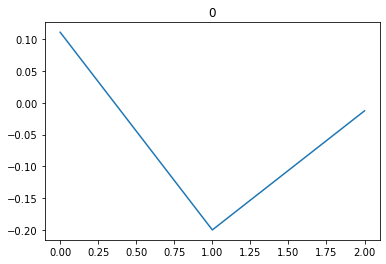

In [16]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(polarity_list[0])
plt.title(disney_df_final['title'].index[0])
plt.show()

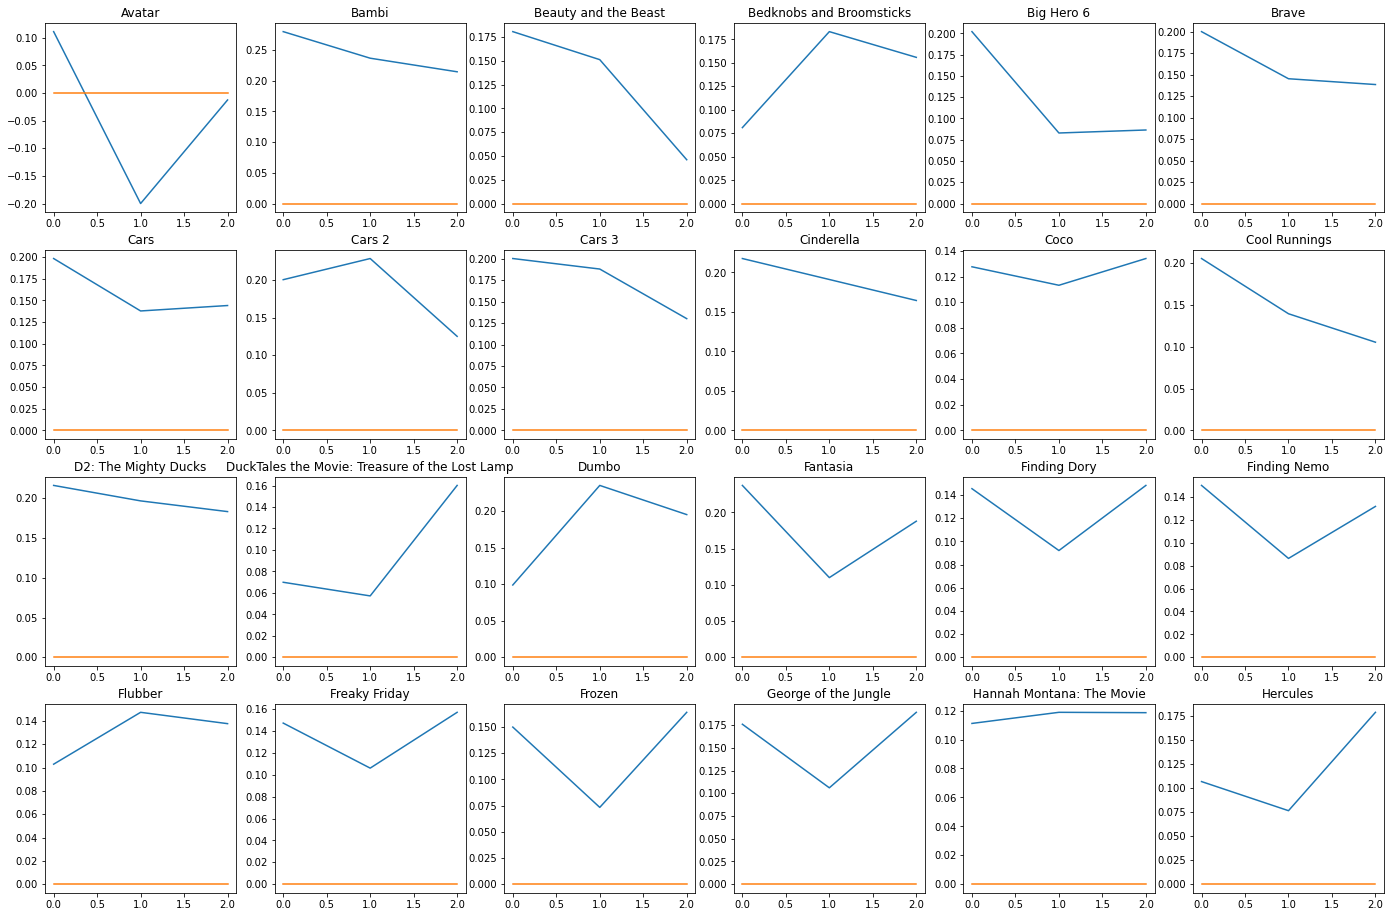

In [17]:
plt.rcParams['figure.figsize'] = [24, 16]

for idx,row in disney_df_final.iterrows():
    if idx >=0 and idx <=23:
#         print (idx)
        plt.subplot(4, 6, idx+1)
        plt.plot(polarity_list[idx])
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title(disney_df_final['title'][idx])
    else:
        break

# plt.show()

In [19]:
disney_df_graph2 = disney_df_final.iloc[24:48,:].reset_index()
polarity_list_graph2 = polarity_list[24:48]

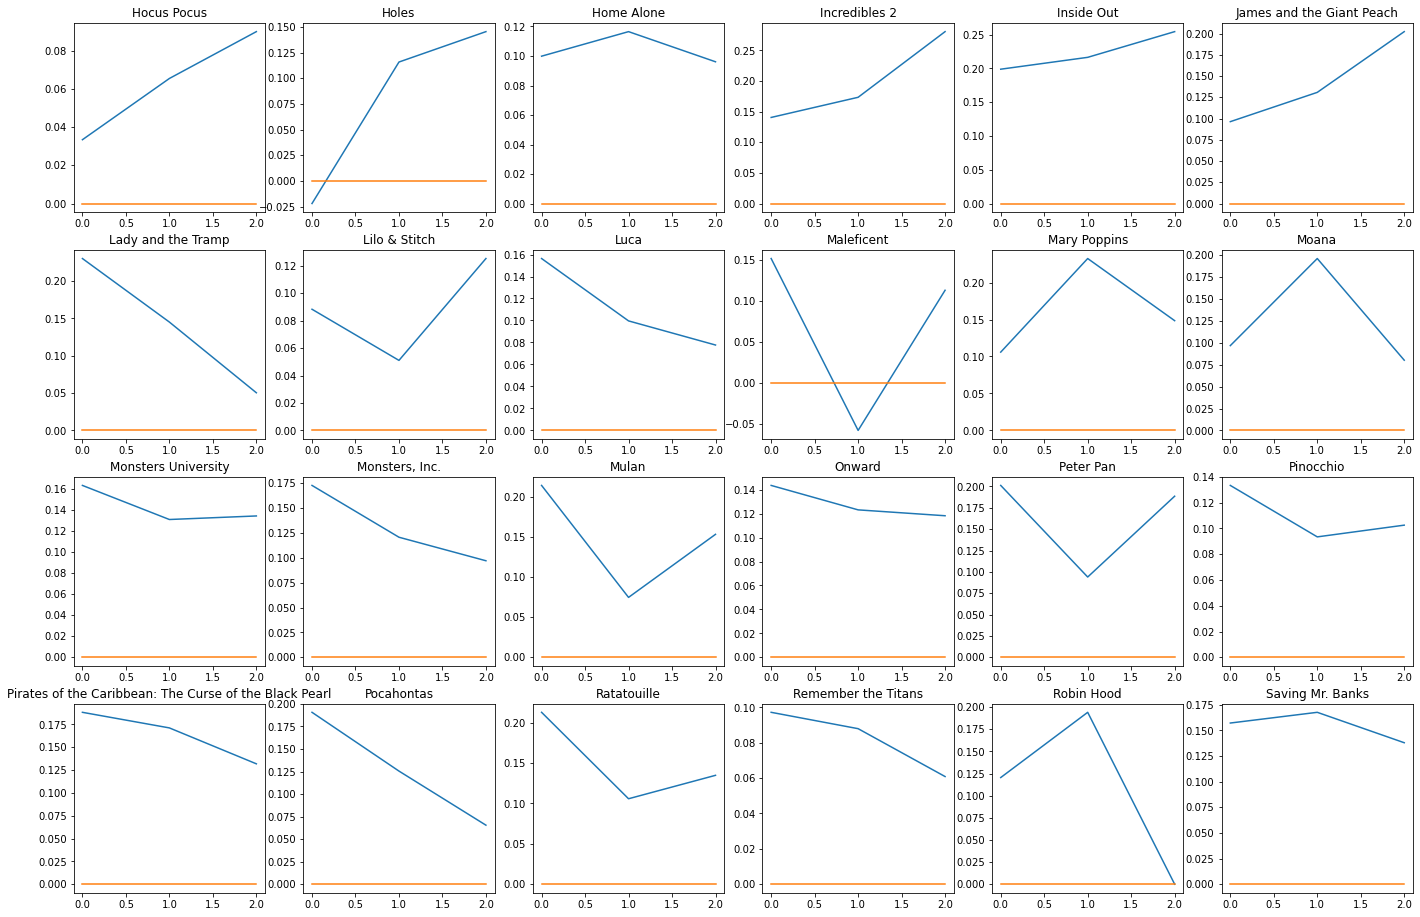

In [20]:
plt.rcParams['figure.figsize'] = [24, 16]

for idx,row in disney_df_graph2.iterrows():
#         print (idx)
    plt.subplot(4, 6, idx+1)
    plt.plot(polarity_list_graph2[idx])
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(disney_df_graph2['title'][idx])


plt.show()

### Inference:

From the graphs, I do see many having a V shaped arc or inverted V arc.  
How many of the movies have this V or Inverted-V arc?

In [187]:
#percent of movies with V arc
i=0
for polarity in polarity_list:
    if ((polarity[0] > polarity[1]) & (polarity[2] > polarity[1])):
        i += 1

print(i/len(polarity_list))

0.3977272727272727


In [188]:
# percent of movies with inverted V arc
j=0
for polarity in polarity_list:
    if ((polarity[0] < polarity[1]) & (polarity[2] < polarity[1])):
        j += 1

print(j/len(polarity_list))

0.2159090909090909


### Inference:

40% of the movies have the V shaped emotional arc while 21% with the inverted V arc. 

<a id='topic'></a>

## Topic Modeling

In [44]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils, models
import scipy.sparse
from nltk import word_tokenize, pos_tag

In [84]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(disney_df_final.subtitles)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = disney_df_final['title']
# data_dtm

In [85]:
data_dtm.head(2)

,aa,aaa,aaaaaaaah,aaaaaaah,aaaaaah,aaaaah,aaaaahhhhh,aaaah,aaah,aaargh,...,zpds,zs,zuider,zulu,zumba,zurg,zurgs,zut,zwei,zydeco
title,,,,,,,,,,,,,,,,,,,,,
Avatar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bambi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# One of the required inputs for gensim- term-document matrix
data_T = data_dtm.transpose()

In [87]:
data_T.head(3)

title,Avatar,Bambi,Beauty and the Beast,Bedknobs and Broomsticks,Big Hero 6,Brave,Cars,Cars 2,Cars 3,Cinderella,...,Tuck Everlasting,Up,Who Framed Roger Rabbit,Zootopia,10 Things I Hate About You,101 Dalmatians,A Bug's Life,Aladdin,Alice in Wonderland,Atlantis: The Lost Empire
aa,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaa,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Word Count Analysis

In [91]:
# Find the top words in each movie
top_dict = {}
for c in data_T.columns:
    top = data_T[c].sort_values(ascending=False).head(10)
    top_dict[c]= list(zip(top.index, top.values))

In [95]:
dict(list(top_dict.items())[0:5])

{'Lady and the Tramp': [('oh', 61),
  ('lady', 34),
  ('come', 29),
  ('hes', 28),
  ('dont', 28),
  ('right', 27),
  ('darling', 26),
  ('little', 25),
  ('hey', 23),
  ('uh', 22)],
 'Lilo & Stitch': [('lilo', 70),
  ('oh', 54),
  ('dont', 43),
  ('like', 37),
  ('im', 35),
  ('uh', 33),
  ('youre', 32),
  ('just', 32),
  ('ka', 30),
  ('know', 29)],
 'Luca': [('just', 65),
  ('dont', 59),
  ('oh', 55),
  ('luca', 50),
  ('yeah', 48),
  ('know', 47),
  ('im', 45),
  ('uh', 44),
  ('hey', 41),
  ('huh', 39)],
 'Maleficent': [('maleficent', 29),
  ('im', 29),
  ('dont', 19),
  ('come', 19),
  ('aurora', 18),
  ('king', 17),
  ('time', 13),
  ('stefan', 13),
  ('know', 13),
  ('need', 12)],
 'Mary Poppins': [('ha', 64),
  ('mary', 41),
  ('dont', 41),
  ('diddle', 40),
  ('oh', 33),
  ('yes', 30),
  ('good', 29),
  ('say', 28),
  ('time', 25),
  ('poppins', 25)],
 'Moana': [('youre', 59),
  ('im', 51),
  ('maui', 47),
  ('know', 44),
  ('moana', 42),
  ('heart', 42),
  ('te', 40),
  ('ju

In [179]:
# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people','didnt','id','day',
                  'youre','got','gonna','time','think','yeah','said','ah','oh','ho','hey','man','hes',
                  'hi','sure','heh','hes','shes','lets','let','way','whoa','yes','ya','yeah','ok','okay',
                  'mr','uh','huh','ta','ha','look','thing','that','like','ill','come','want','say',
                  'tell','wait','miss','going','need','did','aah','ah','aaah','new','what','whats',
                  'ive','theyre','aint','gotta','stop','theres','shall','hmm','hmmm',
                  'youll','make','mean','yall','doing','really','away','wont','buzz','youve',
                  'great','little','subtiles','subtitles','thank','sorry','thanks','dear','sir',
                  'hello','right','left','guys','big','small','nice','gon'
                ]
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [159]:
#redoing after updating stop words
cv2 = CountVectorizer(stop_words=stop_words)
data_cv2 = cv2.fit_transform(disney_df_final.subtitles)
data_dtm2 = pd.DataFrame(data_cv2.toarray(), columns=cv2.get_feature_names())
data_dtm2.index = disney_df_final['title']

In [160]:
data_T2 = data_dtm2.transpose()

In [157]:
data_T2.head(10)

title,Avatar,Bambi,Beauty and the Beast,Bedknobs and Broomsticks,Big Hero 6,Brave,Cars,Cars 2,Cars 3,Cinderella,...,Tuck Everlasting,Up,Who Framed Roger Rabbit,Zootopia,10 Things I Hate About You,101 Dalmatians,A Bug's Life,Aladdin,Alice in Wonderland,Atlantis: The Lost Empire
aa,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaa,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaahhhhh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
aaaah,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
aaargh,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
aaarrgh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
# Find the top words in each movie
top_dict2 = {}
for c in data_T2.columns:
    top = data_T2[c].sort_values(ascending=False).head(10)
    top_dict2[c]= list(zip(top.index, top.values))

In [124]:
# dict(list(top_dict2.items())[:10])

#### LDA - Attempt 1

In [162]:
# Another req - sparse mtx, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_T2)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [163]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv2.vocabulary_.items())

In [153]:
dict(list(id2word.items())[:15])

{10837: 'loaded',
 12086: 'mother',
 17092: 'smile',
 11540: 'meeting',
 17339: 'sound',
 7150: 'formal',
 18012: 'studied',
 21165: 'years',
 10533: 'learn',
 2672: 'calm',
 19479: 'tsutey',
 4857: 'demons',
 7100: 'forbidden',
 16793: 'sign',
 11432: 'matter'}

In [168]:
#LDA - Latent Dirichlet Allocation
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.004*"boy" + 0.004*"help" + 0.003*"dad" + 0.003*"love" + 0.003*"home" + 0.002*"old" + 0.002*"world" + 0.002*"better" + 0.002*"life" + 0.002*"work"'),
 (1,
  '0.004*"boy" + 0.004*"love" + 0.004*"help" + 0.003*"old" + 0.003*"life" + 0.003*"home" + 0.003*"george" + 0.003*"place" + 0.002*"king" + 0.002*"best"'),
 (2,
  '0.004*"help" + 0.004*"love" + 0.003*"boy" + 0.002*"life" + 0.002*"home" + 0.002*"kid" + 0.002*"old" + 0.002*"course" + 0.002*"long" + 0.002*"things"'),
 (3,
  '0.004*"love" + 0.003*"help" + 0.003*"boy" + 0.003*"old" + 0.003*"woody" + 0.003*"mother" + 0.003*"life" + 0.003*"better" + 0.003*"mom" + 0.002*"girl"')]

In [189]:
#LDA - Latent Dirichlet Allocation
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=50)
lda.print_topics()

[(0,
  '0.004*"help" + 0.004*"love" + 0.003*"dad" + 0.003*"home" + 0.003*"boy" + 0.003*"life" + 0.002*"old" + 0.002*"woody" + 0.002*"mom" + 0.002*"long"'),
 (1,
  '0.004*"help" + 0.003*"love" + 0.003*"boy" + 0.002*"old" + 0.002*"peter" + 0.002*"wish" + 0.002*"princess" + 0.002*"captain" + 0.002*"life" + 0.002*"home"'),
 (2,
  '0.004*"boy" + 0.003*"love" + 0.003*"help" + 0.003*"old" + 0.003*"life" + 0.002*"home" + 0.002*"better" + 0.002*"world" + 0.002*"father" + 0.002*"place"')]

#### Inference:
Topic 0:Love(loving/helping)
Topic 1:boy

#### Topic Modeling - Attempt #2 (Nouns Only)

One popular trick is to look only at terms that are from one part of speech (only nouns, only adjectives, etc.). Check out the UPenn tag set: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html.

In [174]:
# from nltk import word_tokenize, pos_tag
# Import from nltx for below ops
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [175]:
data_nouns = pd.DataFrame(disney_df_final.subtitles.apply(nouns))

In [47]:
data_nouns.head(2)

,subtitles
0,subtiles mother smile meeting i years people d...
1,love song life hope music day dawn love song t...


In [180]:
# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.subtitles)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
# data_dtmn

In [181]:
### Prep for LDA

# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [186]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=25)
ldan.print_topics()

[(0,
  '0.006*"boy" + 0.005*"life" + 0.005*"home" + 0.004*"things" + 0.004*"world" + 0.004*"place" + 0.004*"family" + 0.003*"night" + 0.003*"heart" + 0.003*"course"'),
 (1,
  '0.005*"life" + 0.004*"mom" + 0.004*"things" + 0.004*"night" + 0.004*"home" + 0.003*"course" + 0.003*"dad" + 0.003*"place" + 0.003*"woody" + 0.003*"boy"')]

#### Inference: 
Topic 0 - Life/World
Topic 1 - family/dad/mom

#### Topic Modeling - Attempt #2 (Nouns and Adjectives Only)

In [79]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [170]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(disney_df_final.subtitles.apply(nouns_adj))
# data_nouns_adj

In [183]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.subtitles)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
# data_dtmna

In [184]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [187]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=25)
ldana.print_topics()

[(0,
  '0.003*"father" + 0.003*"dad" + 0.003*"girl" + 0.002*"family" + 0.002*"son" + 0.002*"school" + 0.002*"dead" + 0.002*"team" + 0.002*"friend" + 0.002*"kid"'),
 (1,
  '0.003*"mom" + 0.003*"girl" + 0.003*"woody" + 0.003*"dad" + 0.002*"guy" + 0.002*"mother" + 0.002*"heart" + 0.002*"years" + 0.002*"room" + 0.002*"family"')]